In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings("ignore")

In [2]:
trans = pd.read_csv('dh_transactions.csv')
prod = pd.read_csv('dh_product_lookup.csv')

In [3]:
qty = trans[trans['upc'].isin([9999985004,3620000250])]
qty = qty.groupby(['upc','week'])[['units','dollar_sales']].sum().reset_index()
qty

,upc,week,units,dollar_sales
0,3620000250,1,556,1113.77
1,3620000250,2,632,1199.58
2,3620000250,3,1654,2447.96
3,3620000250,4,1556,2251.52
4,3620000250,5,689,1282.01
...,...,...,...,...
203,9999985004,100,1700,952.47
204,9999985004,101,2215,1120.66
205,9999985004,102,1690,848.75
206,9999985004,103,1967,988.41


Text(0, 0.5, 'units')

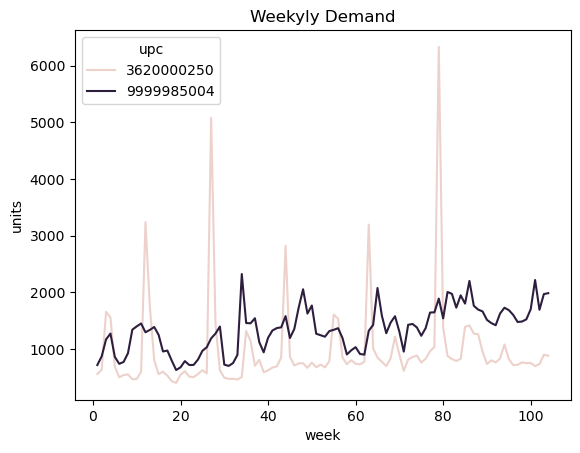

In [4]:
plt.title('Weekyly Demand')
sb.lineplot(data=qty,x='week',y='units',hue='upc')
plt.ylabel('units')

Text(0, 0.5, 'Sales USD')

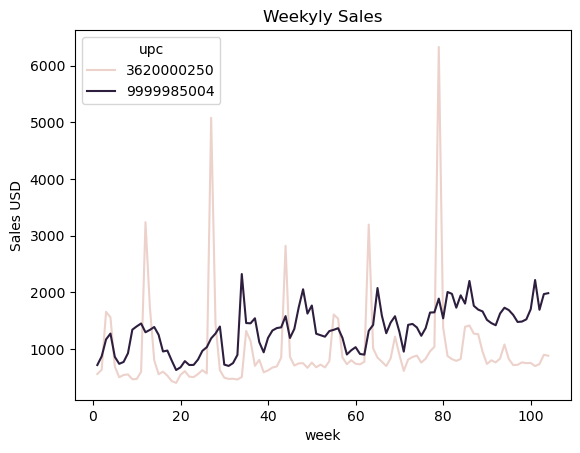

In [5]:
plt.title('Weekyly Sales')
sb.lineplot(data=qty,x='week',y='units',hue='upc')
plt.ylabel('Sales USD')

In [6]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

In [7]:
idx = pd.PeriodIndex(
    pd.date_range("01/01/2021", "31/12/2022", freq="w"), freq="W"
)
idx.to_timestamp()

DatetimeIndex(['2020-12-28', '2021-01-04', '2021-01-11', '2021-01-18',
               '2021-01-25', '2021-02-01', '2021-02-08', '2021-02-15',
               '2021-02-22', '2021-03-01',
               ...
               '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07',
               '2022-11-14', '2022-11-21', '2022-11-28', '2022-12-05',
               '2022-12-12', '2022-12-19'],
              dtype='datetime64[ns]', length=104, freq='W-MON')

In [8]:
pasta = qty[qty['upc'] == 3620000250].drop(columns=['dollar_sales','upc','week'])
pasta = pasta.set_index(idx.to_timestamp())
pasta.iloc[83]

units    822
Name: 2022-08-01 00:00:00, dtype: int64

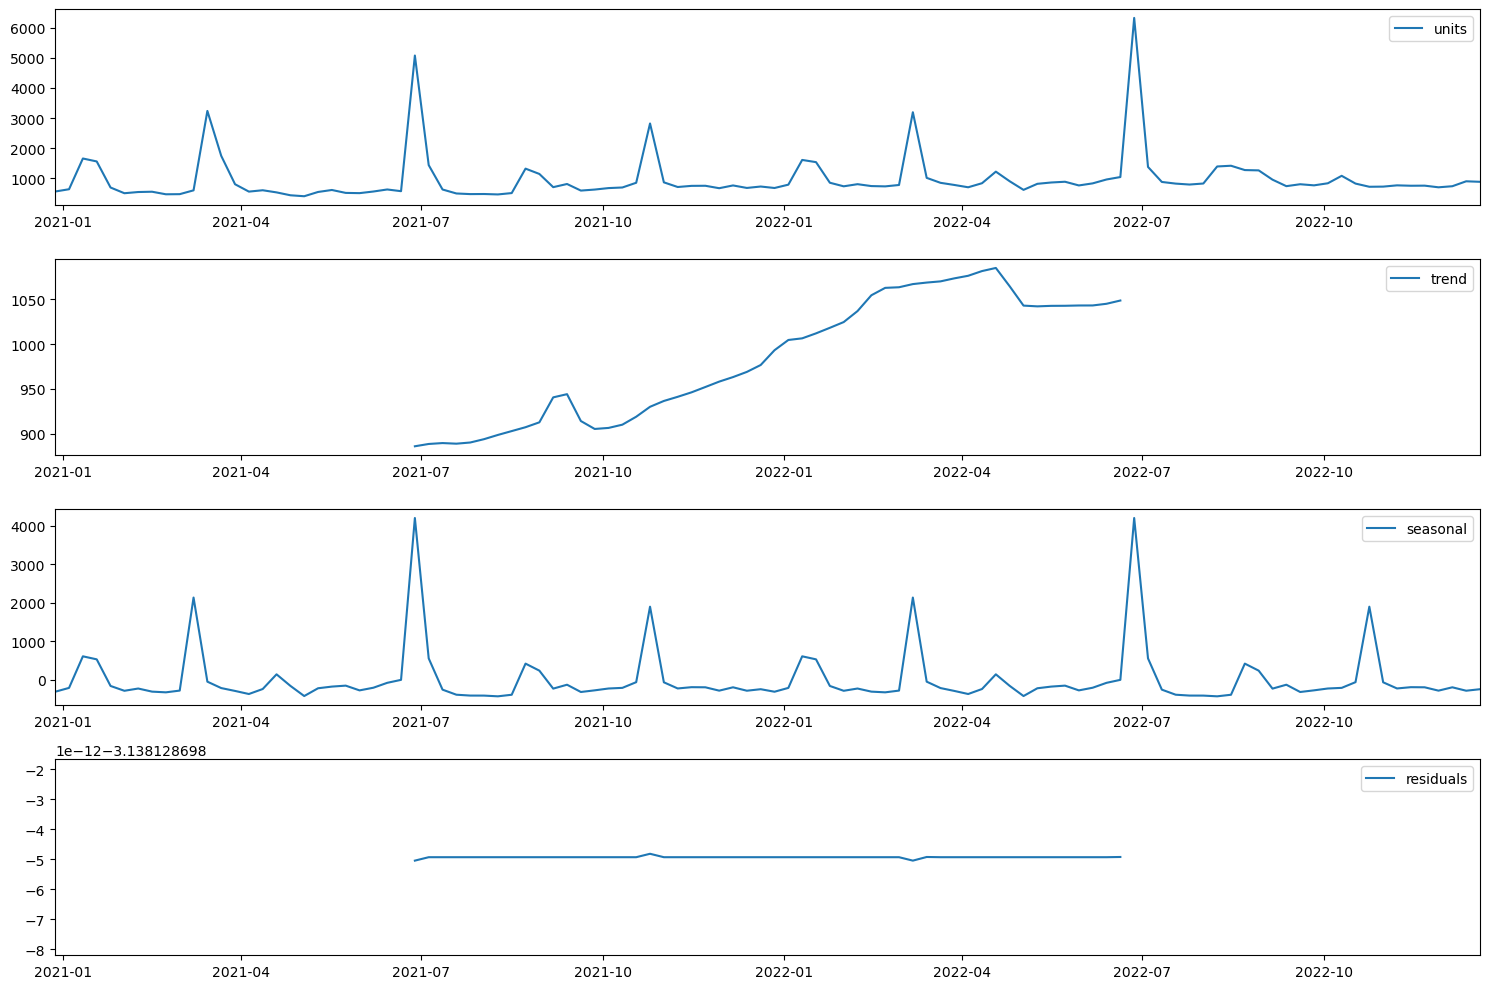

In [9]:
decom = seasonal_decompose(pasta)
pasta['trend'] = decom.trend
pasta['seasonal'] = decom.seasonal
pasta['residuals'] = decom.resid
#trend = decom.trend
#season = decom.seasonal
#resid = decom.resid

#decomposition = [[pasta,'OG'], [trend,'trend'], [season,'seasonal'], [resid,'residual']]
decomposition = ['units','trend','seasonal','residuals']

plt.figure(figsize=(15,10))
for i, d in enumerate(decomposition):
    plt.subplot(4,1, i+1)
    plt.plot(pasta[d],label=d)
    plt.legend()
    plt.xlim(pasta.index[0],pasta.index[-1])
plt.tight_layout()

In [10]:
#pasta['trend'] = trend
#pasta['trend'] = decom['trend'].fillna(value=984.3304363905326)
pasta.drop(columns='trend',inplace=True)
pasta['seasonal'] = pasta['seasonal'].fillna(value=pasta['seasonal'].mean())
pasta['residuals'] = pasta['residuals'].fillna(value=pasta['residuals'].mean())
pasta

,units,seasonal,residuals
2020-12-28,556,-317.083025,-3.138129
2021-01-04,632,-217.525333,-3.138129
2021-01-11,1654,602.647744,-3.138129
2021-01-18,1556,524.080436,-3.138129
2021-01-25,689,-167.131102,-3.138129
...,...,...,...
2022-11-21,751,-201.929179,-3.138129
2022-11-28,696,-288.958025,-3.138129
2022-12-05,732,-202.025333,-3.138129
2022-12-12,896,-290.823410,-3.138129


In [11]:
#Split 80:20
split = '2022-08-01'
train = pasta.loc[pasta.index < split]
test = pasta.loc[pasta.index >= split]
feat = ['units','seasonal','residuals']
X_train = train[feat]
y_train = train['units']

X_test = test[feat]
y_test = test['units']

(18624.0, 19345.0)

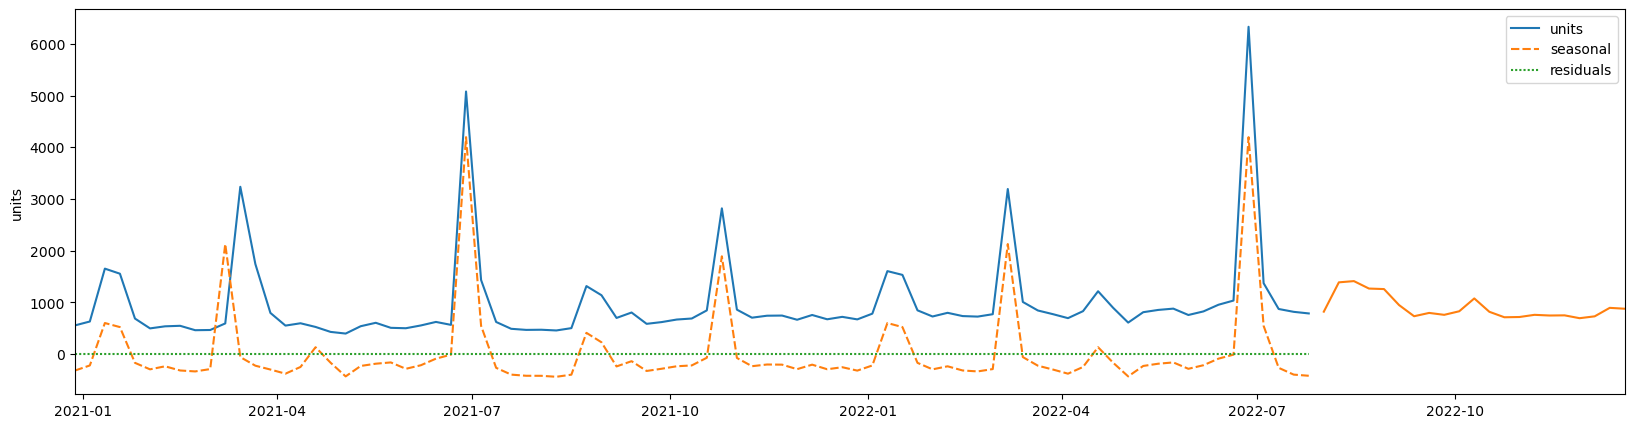

In [12]:
plt.figure(figsize=(20,5))
sb.lineplot(data=train)
sb.lineplot(data=y_test)
plt.xlim(pasta.index[0],pasta.index[-1])

In [13]:
reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1329.18608	validation_1-rmse:924.04293
[100]	validation_0-rmse:619.46200	validation_1-rmse:354.52305
[200]	validation_0-rmse:311.48077	validation_1-rmse:152.31203
[300]	validation_0-rmse:171.87708	validation_1-rmse:73.99177
[400]	validation_0-rmse:100.06615	validation_1-rmse:46.13567
[500]	validation_0-rmse:59.44999	validation_1-rmse:33.17700
[600]	validation_0-rmse:35.74116	validation_1-rmse:27.76855
[700]	validation_0-rmse:21.62059	validation_1-rmse:25.48694
[800]	validation_0-rmse:13.10569	validation_1-rmse:24.46666
[900]	validation_0-rmse:7.95050	validation_1-rmse:23.95605
[999]	validation_0-rmse:4.84856	validation_1-rmse:23.68361


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

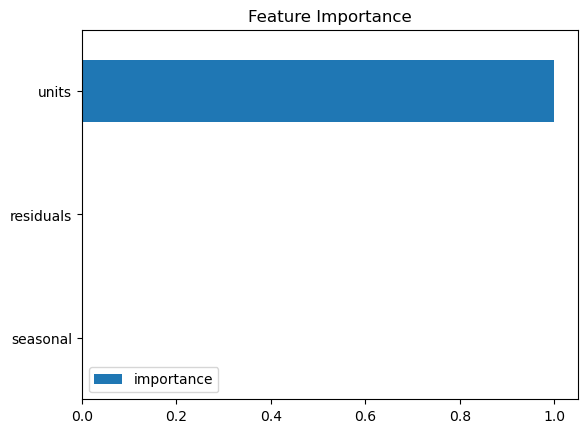

array([1., 0., 0.], dtype=float32)

In [14]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()
reg.feature_importances_

Text(0.5, 1.0, 'Demand forecasting')

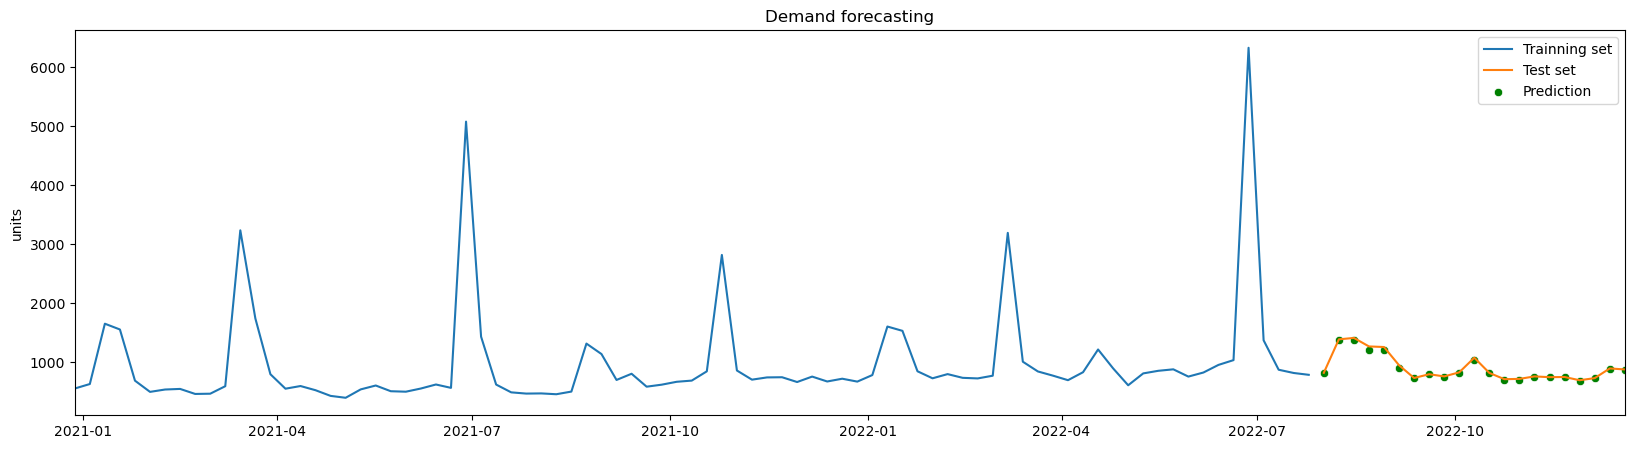

In [15]:
pred = reg.predict(X_test)
plt.figure(figsize=(20,5))
sb.lineplot(data=train['units'],label='Trainning set')
sb.lineplot(data=y_test,label='Test set')
sb.scatterplot(x=test.index,y=pred,label='Prediction',color='green')
plt.xlim(pasta.index[0],pasta.index[-1])
plt.legend()
plt.title("Demand forecasting")

In [16]:
score = np.sqrt(mean_squared_error(test['units'], pred))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 23.68


In [21]:
test['error'] = np.abs(test['units'] - pred)
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-09-05    53.529602
2022-08-22    52.685791
2022-08-29    42.685791
2022-10-10    41.616699
2022-08-15    40.772339
2022-08-08    16.772339
2022-12-12    15.501892
2022-10-31    13.062134
2022-10-24     8.062134
2022-11-28     6.015625
Name: error, dtype: float64